# Project work: A mini segmentation challenge

Imaging for the Life Sciences  
MSLS / CO4: Project work

**Student**: $\Rightarrow$  Guansheng Du    
**University**: $\Rightarrow$  ZHAW  
**Semester**: $\Rightarrow$  SS24   
**Date**: $\Rightarrow$  26.05.2024 




## Table of contents

<!-- Unfortunately, the following does not always work correctly -->

* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  
* [*. Hints](#sec_hints)  


## Introduction

Lower-grade gliomas (LGG) are a group of WHO WHO grade II and grade III brain tumors. In this mini project homework, I implemented a neural networking based program to segment the cancer region of a serious of MRI brain images. In this programming, the files were loaded in a dataframe df. 

This dataset contains brain MR images together with manual FLAIR abnormality segmentation masks.
The images were obtained from The Cancer Imaging Archive (TCIA).
They correspond to 110 patients included in The Cancer Genome Atlas (TCGA) lower-grade glioma collection with at least fluid-attenuated inversion recovery (FLAIR) sequence and genomic cluster data available.

For more information about the dataset:
[https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

---

## Prerequisites / Setup

$\Rightarrow$  Special setup instructions, imports and configurations go here.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
import pydicom
import PIL
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

import sys
sys.path.insert(0, "../")
import tools

data_folder = '/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Help functions

In [3]:
# Sort filenames in natural order
# Generated by AI

import re

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)



In [146]:
# Check if the file has a mask

def check_mask(file):
    # Open the file
    image = Image.open(file)

    # Convert the image to an array
    image_array = np.array(image)

    # Check if there is a white pixel
    if np.any(image_array > 0):
        return 1
    else:
        return 0

In [147]:
# Display the 16 images with their masks

def image_plots(df, indices):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.loc[index, "image_path"])
        mask = Image.open(df.loc[index, "mask_path"])

        ax = axs[i // 4, i % 4]
        ax.imshow(image)
        ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        mask_status = "Mask" if df.loc[index, "check_mask"] == 1 else "No mask"
        ax.set_title(f"Index: {index}\n{mask_status}")
    
    plt.tight_layout()
    plt.show()

---


<a id='sec_dataset'></a>

## Dataset




In [ ]:
import os
import pandas as pd

# Get a list of all .tif files in the data folder
tif_files = [f for f in os.listdir(data_folder) if f.endswith(".tif")]

# Sort the list of files in natural order
tif_files = natural_sort(tif_files)
tif_files

In [5]:
# Create a DataFrame

mask_files = [f for f in tif_files if "_mask" in f]
image_files = [f for f in tif_files if "_mask" not in f]

df = pd.DataFrame({"image_file": image_files, "mask_file": mask_files})
df.head()

,image_file,mask_file
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif


In [6]:
from PIL import Image
import numpy as np

df['mask_path'] = df.mask_file.apply(lambda x: data_folder + x)
df['image_path'] = df.image_file.apply(lambda x: data_folder + x)

df.head()

,image_file,mask_file,mask_path,image_path
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...


In [8]:
df["check_mask"] = df["mask_path"].apply(check_mask)

df.head()

,image_file,mask_file,mask_path,image_path,check_mask
0,TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909_1_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
1,TCGA_CS_4941_19960909_2.tif,TCGA_CS_4941_19960909_2_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
2,TCGA_CS_4941_19960909_3.tif,TCGA_CS_4941_19960909_3_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
3,TCGA_CS_4941_19960909_4.tif,TCGA_CS_4941_19960909_4_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0
4,TCGA_CS_4941_19960909_5.tif,TCGA_CS_4941_19960909_5_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,0


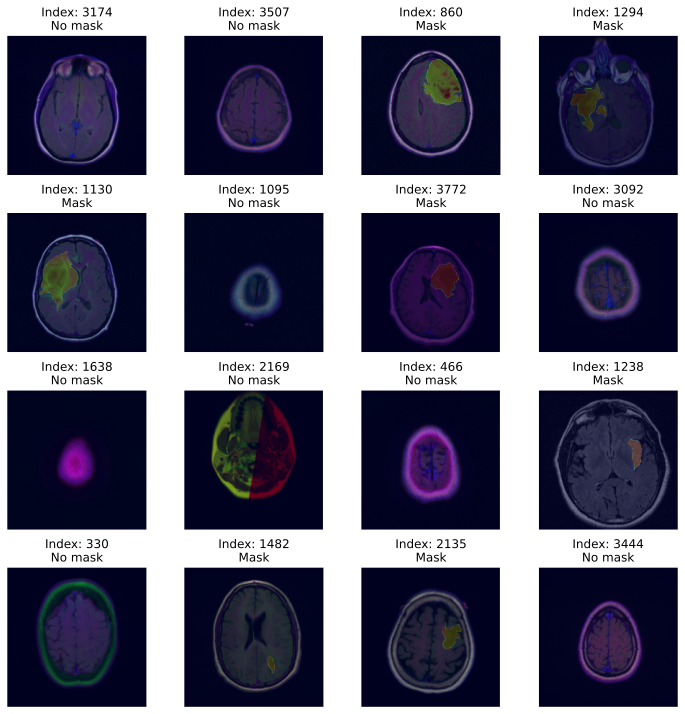

In [153]:
np.random.seed(42)

# Generate 16 random indices
indices = np.random.randint(0, len(df), 16)

image_plots(df, indices)

---

<a id='sec_preprocessing'></a>

## Preprocessing

$\Rightarrow$ Describe the pre-processing that was required to complete the segmentation task.

Each image was transformed before 


### Goals:
* Choose a method that scales well for larger datasets
* Improve the datasets for easier processing

In [100]:


"""
data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.5),

    ]
)
"""

class data_transform():
    def __init__(self, transform_type="train", image_size=128):
        self.image_size = image_size
        if transform_type == "train":
            self.transform = transforms.Compose(
                [
                    transforms.Resize((self.image_size, self.image_size)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.5),
                    transforms.ToImage(),
                    transforms.ToDtype(torch.float32, scale=True),
                ]
            )
        else:
            self.transform = transforms.Compose(
                [
                    transforms.Resize((self.image_size, self.image_size)),
                    transforms.ToImage(),
                    transforms.ToDtype(torch.float32, scale=True),
                ]
            )
    
    def __call__(self, image):
        return self.transform(image)

In [121]:
def plot_model_results(image, mask, predict):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.33))

    axs[0].imshow(transforms.ToPILImage()(image))
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(transforms.ToPILImage()(mask), cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    axs[2].imshow(transforms.ToPILImage()(predict.squeeze(0)), cmap="gray")
    axs[2].set_title("Predicted mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

In [152]:
%%capture

# Visualization code (for example purposes, visualize the first batch)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(images[0].cpu()))
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(transforms.ToPILImage()(masks[0].cpu()), cmap="gray")
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()


---

<a id='sec_manual_segmentation'></a>

## Manual segmentation

$\Rightarrow$ Describe the manual segmentation step

A researcher who was a medical school graduate with experience in neuroradiology imaging, manually annotated FLAIR images by drawing an outline of the FLAIR abnormality on each slice to form training data for the automatic segmentation algorithm. For more details about the manual segmentation, 


### Goals:
* Segment structures of interest using a tool  
* These structures you need to 
* If you find a dataset that comes with segmentation masks, you still need to demonstrate how to create such masks!

---

<a id='sec_automated_segmentation'></a>

## Automated segmentation

$\Rightarrow$ Describe how to segment the image in Python

A neural network was applied to segment the images in this project. 


### Goals:
* The segmentation must be performed in Python.
* Using an external library or tool (e.g. OpenCV) is permitted.
* Implement a function `segment(image, ...)` takes an image as input and creates a segmentation mask for the structure of interest.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
# train_df = df.sample(frac=0.8, random_state=42)
# test_df = df.drop(train_df.index)
# Use only the images with masks

df_mask = df[df["check_mask"] == 1]
train_df = df_mask.sample(frac=0.8, random_state=42)
test_df = df_mask.drop(train_df.index)


train_df.shape, test_df.shape

((1098, 5), (275, 5))

In [21]:
df_mask.head()

,image_file,mask_file,mask_path,image_path,check_mask
10,TCGA_CS_4941_19960909_11.tif,TCGA_CS_4941_19960909_11_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
11,TCGA_CS_4941_19960909_12.tif,TCGA_CS_4941_19960909_12_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
12,TCGA_CS_4941_19960909_13.tif,TCGA_CS_4941_19960909_13_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
13,TCGA_CS_4941_19960909_14.tif,TCGA_CS_4941_19960909_14_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1
14,TCGA_CS_4941_19960909_15.tif,TCGA_CS_4941_19960909_15_mask.tif,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,/home/gs/Desktop/SS24 CO4 Imaging for the Life...,1


In [22]:
from PIL import Image

import torch
from torch.utils.data import Dataset
import random

# Class to create a custom dataset

class CustomImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def load_image(self, idx):
        image = Image.open(self.df.iloc[idx, "image_path"])
        mask = Image.open(self.df.iloc[idx, "mask_path"])
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.df["image_path"].iloc[idx]
        mask_name = self.df["mask_path"].iloc[idx]

        image = Image.open(img_name)
        mask = Image.open(mask_name)
        
        image, mask = self.transforms(image, mask)

        return image, mask

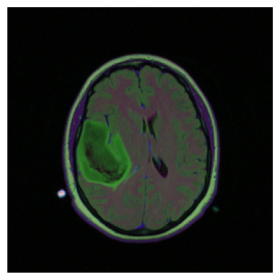

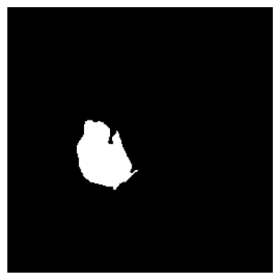

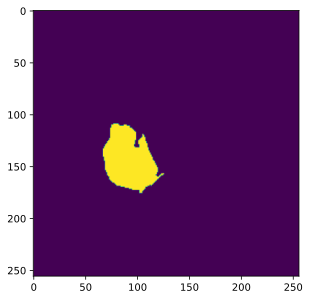

In [23]:
import matplotlib.image as mpimg


image = Image.open(train_df.iloc[16]["image_path"])
mask = Image.open(train_df.iloc[16]["mask_path"])


plt.imshow(image)
plt.axis("off")
plt.show()

plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

img = mpimg.imread(train_df.iloc[16]["mask_path"])
plt.imshow(img)
plt.show()

In [29]:
image.info

{'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}

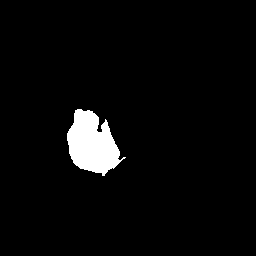

In [56]:
mask

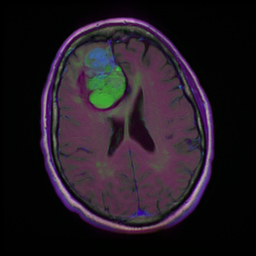

In [119]:
Image.open(train_df.iloc[10]["image_path"])


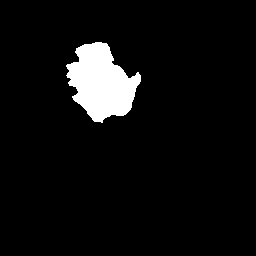

In [120]:

Image.open(train_df.iloc[10]["mask_path"])


In [123]:

train_dataset = CustomImageDataset(train_df, transforms=data_transform)
test_dataset = CustomImageDataset(test_df, transforms=data_transform(transform_type="test"))


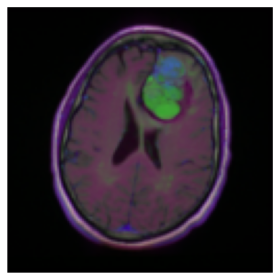

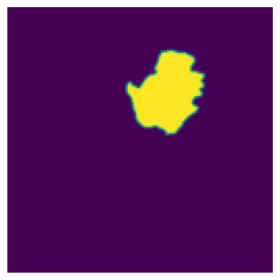

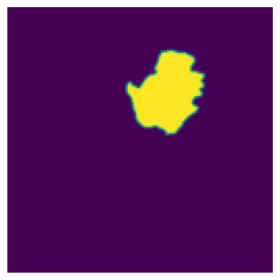

In [77]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms



image, mask = train_dataset[10]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0))
plt.axis("off")
plt.show()

mask3 = transforms.ToPILImage()(mask)

plt.imshow(mask3)
plt.axis("off")
plt.show()

In [65]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7f324efaa3d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f32a44a1d50>)

In [66]:
image, mask = next(iter(train_loader))
image.shape, mask.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

In [67]:
os.cpu_count()

6

In [68]:
train_df["image_path"].iloc[0]

'/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif'

In [69]:
train_df.iloc[0, train_df.columns.get_loc("image_path")]


'/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif'

In [70]:
train_dataset[0][0]

Image([[[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]],

       [[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]], )

/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/TCGA_DU_7014_19860618_27.tif


(-0.5, 127.5, 127.5, -0.5)

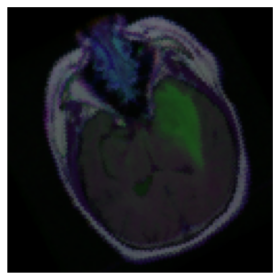

In [71]:
print(train_df.iloc[0]['image_path'])
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.axis("off")


## U-Net 3

In [141]:
# Model building, inspired by the U-Net from Kaggle

import torch
import torch.nn as nn


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            in_channels // 2, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 3
        self.n_classes = 1
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Create the UNet model
model = UNet().to(device)

## Training

In [72]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
import torch


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.sigmoid()  # Apply sigmoid to clamp between 0 and 1
        intersection = (
            predictions * targets
        ).sum()  # Element-wise multiplication and sum
        dice = (2.0 * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )
        return 1 - dice
    
dice_loss = DiceLoss()

In [143]:
%%capture
plt.imshow(image[0].permute(1, 2, 0))

In [74]:
mask_t = model(image.to(device))
mask_t.shape

torch.Size([16, 1, 128, 128])

In [ ]:
plt.imshow(mask_t[0].permute(1,2,0), cmap="gray")

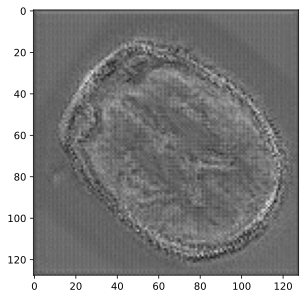

In [75]:
plt.imshow(mask_t[0].detach().cpu().numpy().squeeze(), cmap="gray")

Epoch 1/30, Training Loss: 0.9472
Epoch 1/30, Validation Loss: 0.9518


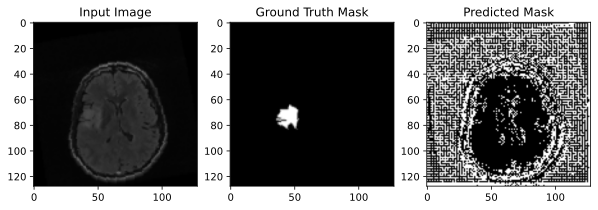

KeyboardInterrupt: 

In [145]:
num_epochs = 30

torch.manual_seed(42)
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        optimizer.zero_grad()

        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        # Resize masks to match the size of outputs
        # masks = torch.nn.functional.interpolate(masks, size=outputs.size()[2:], mode='bilinear', align_corners=False).to(device)
        

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    if epoch % 1 == 0:

        model.eval()
        with torch.no_grad():
            
            testing_loss = 0.0

            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                preds = preds > 0.5  # Apply threshold

                loss = dice_loss(outputs, masks)
                testing_loss += loss.item() * images.size(0)
                
            val_loss = testing_loss / len(test_loader.dataset)
            val_loss_history.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

            # Visualization code (for example purposes, visualize the first batch)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(transforms.ToPILImage()(images[0].cpu()))
            plt.title("Input Image")

            plt.subplot(1, 3, 2)
            plt.imshow(transforms.ToPILImage()(masks[0].cpu()), cmap="gray")
            plt.title("Ground Truth Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")
            plt.title("Predicted Mask")

            plt.show()
            
            #plot_model_results(images[0], masks[0], preds[0].squeeze(0))
            



In [130]:
model = UNet().to(device)  # Replace with your actual model architecture
model.load_state_dict(torch.load("unet0.pth"))

<All keys matched successfully>

In [131]:
outputs = model(images)
preds = torch.sigmoid(outputs)
preds = preds > 0.5  # Apply threshold

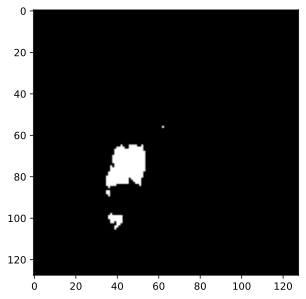

In [132]:
plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")

ValueError: cannot select an axis to squeeze out which has size not equal to one

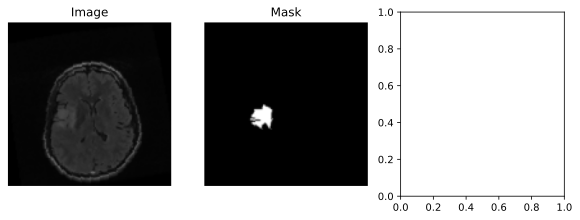

In [138]:
plot_model_results(images[0], masks[0], preds[0].squeeze().cpu().numpy())

In [ ]:

torch.save(model.state_dict(), "unet.pth")

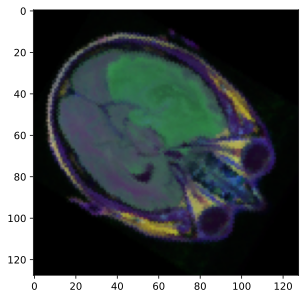

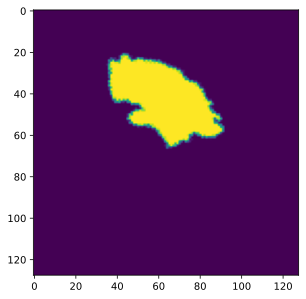

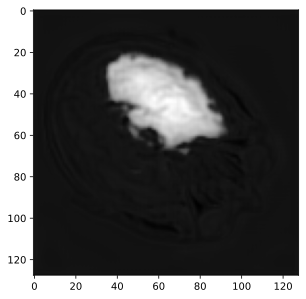

In [147]:
image, mask = next(iter(test_loader))

image = image.to(device)
mask = mask.to(device) 

plt.imshow(image[8].permute(1, 2, 0).detach().cpu().numpy().squeeze())
plt.show()

plt.imshow(mask[8].permute(1, 2, 0).detach().cpu().numpy().squeeze())
plt.show()

image_t = model(image)
plt.imshow(image_t[8].detach().cpu().numpy().squeeze(), cmap="gray")

---

<a id='sec_evaluation'></a>

## Evaluation

$\Rightarrow$ Describe the evaluation of your results


### Goals:
* Choose an evaluation method that can compare two binary segmentation masks and computes a numeric score that describes how well these masks match (use for example the Dice score)
* Hint: specify a function `evaluate(mask1, mask2)` that computes the evaluation score(s)
* Compute mean and standard deviation of the scores of the entire dataset

In [148]:
def plot_side_by_side(image, mask, title1="Image", title2="Mask"):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title(title1)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(title2)
    plt.axis("off")
    plt.show()

In [151]:
def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

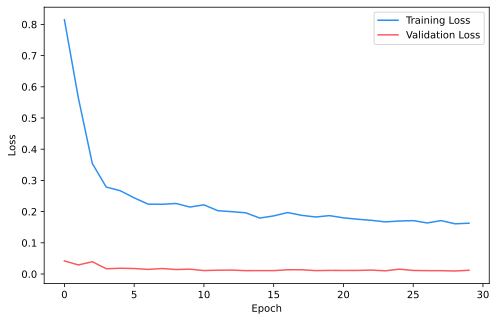

In [152]:
plot_losses(train_loss_history, val_loss_history)

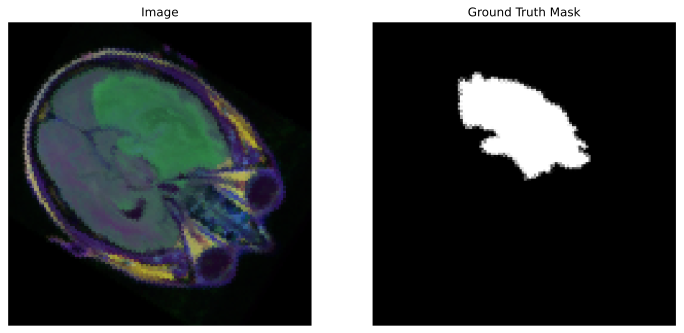

In [153]:
plot_side_by_side(
    image[8].permute(1, 2, 0).detach().cpu().numpy().squeeze(),
    mask[8].permute(1, 2, 0).detach().cpu().numpy().squeeze(),
    title1="Image",
    title2="Ground Truth Mask",
)

In [154]:
import numpy as np


def evaluate_segmentation(pred, target, n_classes=2):
    """
    Compute Intersection over Union score (IoU).

    Parameters:
    pred (numpy.ndarray): Predicted segmentation mask.
    target (numpy.ndarray): Ground truth segmentation mask.
    n_classes (int): Number of classes in the segmentation.

    Returns:
    float: IoU score.
    """
    iou_list = []
    pred = pred.view(-1)
    target = target.view(-1)

    for sem_class in range(n_classes):
        pred_inds = pred == sem_class
        target_inds = target == sem_class
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = (
            pred_inds.long().sum().data.cpu().item()
            + target_inds.long().sum().data.cpu().item()
            - intersection
        )
        if union == 0:
            iou_list.append(
                float("nan")
            )  # If there is no ground truth, do not include in evaluation
        else:
            iou_list.append(float(intersection) / float(max(union, 1)))
    return np.nanmean(iou_list)  # Return average IoU score of all classes

In [156]:
import matplotlib.pyplot as plt


def overlay_segmentation(image, pred, target):
    """
    Overlay segmentation masks on the original image.

    Parameters:
    image (numpy.ndarray): Original image.
    pred (numpy.ndarray): Predicted segmentation mask.
    target (numpy.ndarray): Ground truth segmentation mask.

    Returns:
    None
    """
    # Create a color map for visualizing the masks
    colors = [(0, 0, 0), (255, 0, 0), (0, 255, 0), (0, 0, 255)]
    cmap = plt.cm.colors.ListedColormap(colors)

    # Normalize the masks to [0, 1] for visualization
    pred = pred / np.max(pred)
    target = target / np.max(target)

    # Create the overlay by adding the masks to the image
    overlay = image.copy()
    overlay[pred > 0] += pred[pred > 0]
    overlay[target > 0] += target[target > 0]

    # Display the overlay
    plt.imshow(overlay, cmap=cmap)
    plt.show()

In [ ]:
image, mask = next(iter(test_loader))

image = image.to(device)
mask = mask.to(device)

plt.imshow(image[8].permute(1, 2, 0).detach().cpu().numpy().squeeze())
plt.show()
plt.axis("off")

plt.imshow(mask[8].permute(1, 2, 0).detach().cpu().numpy().squeeze(), cmap="gray")
plt.show()
plt.axis("off")

image_t = model(image)
plt.imshow(image_t[8].detach().cpu().numpy().squeeze(), cmap="gray")
plt.axis("off")

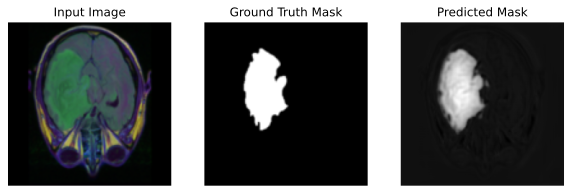

In [198]:
# Visualization code (for example purposes, visualize the first batch)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(transforms.ToPILImage()(image[8].cpu()))
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(transforms.ToPILImage()(mask[8].cpu()), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image_t[8].detach().cpu().numpy().squeeze(), cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [202]:
image_t[8].detach().cpu().numpy().squeeze().shape

(128, 128)

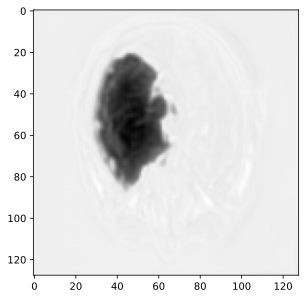

In [205]:
plt.imshow(image_t[8].detach().cpu().numpy().squeeze(), cmap="binary")

In [204]:
mask[8].shape

torch.Size([1, 128, 128])

In [173]:
overlay_segmentation(
    image[8].permute(1, 2, 0).detach().cpu().numpy().squeeze(),
    image_t[8].detach().cpu().numpy().squeeze(),
    mask[8].permute(1, 2, 0).detach().cpu().numpy().squeeze(),
)

ValueError: operands could not be broadcast together with shapes (1705,3) (1705,) (1705,3) 

In [192]:
index = 8
image = Image.open(df_mask.iloc[index]["image_path"])

mask_estimate = model(image.detach().cpu().numpy().squeeze())

AttributeError: 'TiffImageFile' object has no attribute 'detach'

TypeError: Compose.forward() got an unexpected keyword argument 'image'

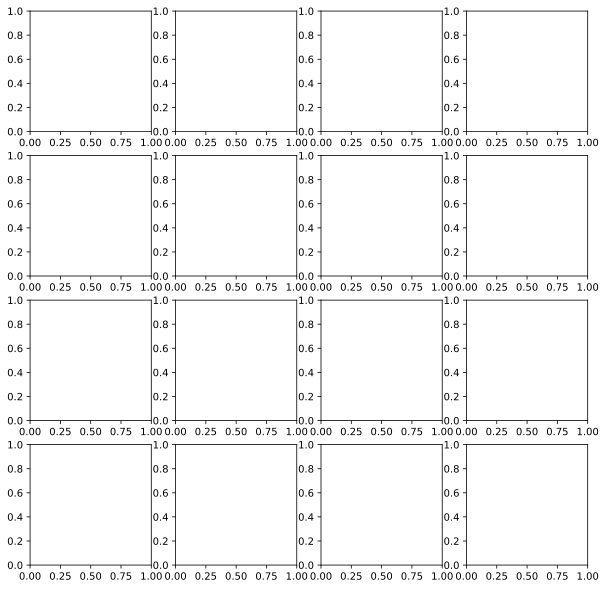

In [188]:
# Generate 16 random indices
indices = np.random.randint(0, len(df_mask), 16)

# Create a figure for the subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

# Loop over the indices
for i, index in enumerate(indices):
    # Read the image and mask
    
    image = Image.open(df_mask.iloc[index]["image_path"])
    mask = Image.open(df_mask.iloc[index]["mask_path"])
    

    # Create a subplot for the image and mask
    ax = axs[i // 4, i % 4]
    ax.imshow(image, cmap="gray")
    ax.imshow(mask, cmap="jet", alpha=0.5)  # Overlay the mask on the image
    ax.imshow(mask_estimate[0].detach().cpu().numpy().squeeze(), cmap="jet", alpha=0.5)  # Overlay the mask on the image
    ax.axis("off")

    mask_status = "Mask" if df.loc[index, "check_mask"] == 1 else "No mask"
    ax.set_title(f"Index: {index}\n{mask_status}")


plt.tight_layout()
plt.show()

In [180]:
indices

array([1123,  871,  130, 1332,  769,  343,  805,  385, 1215,  955,  276,
       1184,  459, 1337,   21,  252])

In [164]:
image[8].shape

torch.Size([3, 128, 128])

In [166]:
mask[8].shape

torch.Size([1, 128, 128])

In [168]:
image_t[8].shape

torch.Size([1, 128, 128])

---

<a id='sec_discussion'></a>

## Discussion

$\Rightarrow$ Discuss your results and experiences briefly.




---

<a id='sec_references'></a>

## References

$\Rightarrow$ Add here references as URLs.

Also declare the usage of **generative AI** here!!




<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## Hints:
* Display your data if possible.
* An easy way to show 2D images is using Pillow:


In [ ]:
# Displayin an image with Pillow
path = "../data/images/kidney-cells.jpg"
path = "../data/images/histology-image.jpg"
image = PIL.Image.open(path)
display(image)                  

In [ ]:
# If you keep the data as a numpy array (for example when using
# the OpenCV interface), you can use matplotlib to display it.
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");


In [ ]:
# For convenience, we also provide tools.display_image()
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

There are many ways how to overlay an image with the mask. Here is one option:

In [ ]:
# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))


In [ ]:
# We could also create contours around the mask and display them
overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize the different contours with different colors.

Strategy:
- Use connected components to label the different regions using integers 
(every region has a different label)
- Assign a different color to different labels by encoding the label in 
the hue channel (HSV color space!)
- Extract contours from the mask (must be a binary image)
- Merge draw the contours with the colorized labels onto the original image

In [ ]:
# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

### How to convert a Jupyter notebook into a PDF:

- Don't forget to save this notebook before converting!
- Install nbconvert: `pip install nbconvert`
- Convert the notebook into a HTML file: `jupyter nbconvert --to html main.ipynb`  
  The file will be saved in the same folder as this Jupyter notebook
- Open the HTML in a browser and print (or save) it as a PDF
- Recommendation: If you use the Opera browser, you can save the HTML as single-page PDF. This looks the best!

In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb
